image labels: ['Early', 'Late', 'Viable']
training images: 1836
train random sampler: 1653
validation random sampler: 183
training set: 9
validation set: 1
epoch: 1/50... valid loss: 1.140... valid accuracy:  0.295

epoch: 2/50... valid loss: 1.171... valid accuracy:  0.290

epoch: 3/50... valid loss: 1.129... valid accuracy:  0.437

epoch: 4/50... valid loss: 1.130... valid accuracy:  0.372

epoch: 5/50... valid loss: 0.961... valid accuracy:  0.568

epoch: 6/50... valid loss: 0.826... valid accuracy:  0.705

epoch: 7/50... valid loss: 0.722... valid accuracy:  0.825

epoch: 8/50... valid loss: 0.632... valid accuracy:  0.918

epoch: 9/50... valid loss: 0.610... valid accuracy:  0.951

epoch: 10/50... valid loss: 0.607... valid accuracy:  0.951

epoch: 11/50... valid loss: 0.606... valid accuracy:  0.951

epoch: 12/50... valid loss: 0.607... valid accuracy:  0.945

epoch: 13/50... valid loss: 0.610... valid accuracy:  0.945

epoch: 14/50... valid loss: 0.608... valid accuracy:  0.945


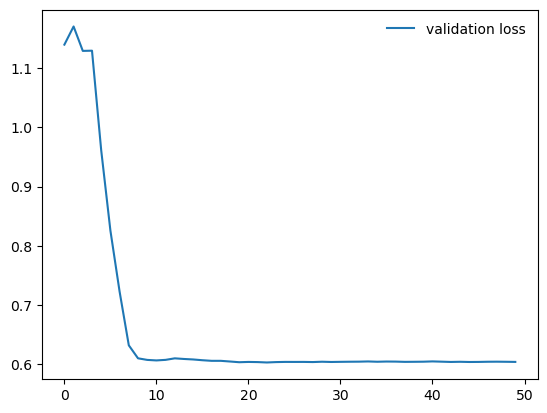

In [1]:
import time
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.utils.data import ConcatDataset, Subset
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

start_time = time.time()

#data directory
#data_dir = r'C:\Users\alexp\Desktop\MCF7_classification\viable_apop\traintest\Vtrain'
#data_dir = r'C:\Users\pinai\OneDrive - East Carolina University\Desktop\MCF7_classification\viable_apop\traintest\Vtrain'
#data_dir = r'C:\Users\pinai\OneDrive - East Carolina University\Documents\MATLAB\Dr_Hu_Projects\Clustering\relabel\new_class\Vtrain'
data_dir = r'C:\Users\alexp\Documents\MATLAB\Dr_Hu_Projects\Clustering\relabel\new_class\Vtrain'


num_classes = 3
batchsize = 184
epochno = 50
resize = 160
# totalin to fc must be product of image dimensions before fc1 - see print(output.size()) on the forward
# function and multiply the last three numbers for the totalin value
totalin = 5120
validsize = 0.1

#training validation groups
train_transforms = transforms.Compose([transforms.Resize(resize),
                                       transforms.ToTensor(),
                                       ])    
                         
test_transforms = transforms.Compose([transforms.Resize(resize),
                                      transforms.
                                      transforms.ToTensor(),
                                      ])    
train_data = datasets.ImageFolder(data_dir,       
                    transform=train_transforms)
test_data = datasets.ImageFolder(data_dir,
                    transform=test_transforms) 
 
num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(validsize * num_train))
np.random.shuffle(indices)

train_idx, test_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
train_loader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=batchsize)
test_loader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=batchsize)

print("image labels: {}".format(train_loader.dataset.classes))
print("training images: {}".format(len(train_data)))
#print("testing images: {}".format(len(test_data)))

print("train random sampler: {}".format(len(train_sampler)))
print("validation random sampler: {}".format(len(test_sampler)))

print("training set: {}".format(len(train_loader)))
print("validation set: {}".format(len(test_loader)))

#convolution layers
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

def conv1x1(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                     stride=stride, padding=0, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


# DINet-R2
class ResNet(nn.Module):
	def __init__(self, block, layers, num_classes = num_classes):
		super(ResNet, self).__init__()
		self.in_channels = 16
		self.conv = conv3x3(3, 16)
		self.bn = nn.BatchNorm2d(16)
		self.relu = nn.ReLU(inplace=True)
		self.layer1 = self.make_layer(block, 32, layers[0])
		self.layer2 = self.make_layer(block, 64, layers[1])
		self.layer3 = self.make_layer(block, 128, layers[2])
		self.pool = nn.AvgPool2d(3, stride = 2)
#		self.pool2 = nn.AvgPool2d(2, stride = 1)
		self.conv4 = conv3x3(128, 256)
		self.bn4 = nn.BatchNorm2d(256)
		self.fc1 = nn.Linear(totalin, num_classes)
		self.softmax = nn.Softmax(dim=1)
       
	def make_layer(self, block, out_channels, blocks, stride=1):
		downsample = None
		if (stride != 1) or (self.in_channels != out_channels):
			downsample = nn.Sequential(
				conv1x1(self.in_channels, out_channels, stride=stride),
				nn.BatchNorm2d(out_channels))
		layers = []
		layers.append(block(self.in_channels, out_channels, stride, downsample))
		self.in_channels = out_channels
		for i in range(1, blocks):
			layers.append(block(out_channels, out_channels))
		return nn.Sequential(*layers)
			

	def forward(self, x):
		out = self.pool(x)
		#print(out.size())
		out = self.conv(out)
		out = self.bn(out)
		out = self.relu(out)
		out = self.pool(out)
		#print(out.size())
		out = self.layer1(out)
		#print(out.size())
		out = self.layer2(out)
		#print(out.size())
		out = self.pool(out)
		#print(out.size())
		out = self.layer3(out)
		#print(out.size())
		out = self.pool(out)
		#print(out.size())
		out = self.conv4(out)
		out = self.bn4(out)
		out = self.relu(out)
		out = self.pool(out)
#		print(out.size())
		#out = self.tanh(out)
		out = out.view(out.size(0), -1)
		out = self.fc1(out)
		#out = self.fc3(out)
		out = self.softmax(out)
		return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(ResidualBlock, [1, 1, 1])
#print(model)
#print(model.fc1.weight.size())
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer.zero_grad()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)

model.to(device)

epochs = epochno
steps = 0
running_loss = 0
train_losses, testloss = [], []
empty_matrix = torch.zeros(num_classes, num_classes)

#training validation
for epoch in range(epochs):
	model.train()
	for images, labels in train_loader:
		steps += 1
		images, labels = images.cuda(), labels.cuda()
		optimizer.zero_grad()
		outputs = model(images)
		loss = criterion(outputs, labels)
		loss.backward()
		optimizer.step()
		running_loss += loss.item()


	with torch.no_grad():
		test_loss = 0
		correct = 0
		total = 0
		model.eval()
		for images, labels in test_loader:
			images, labels = images.cuda(), labels.cuda()
			outputs = model(images)
			batch_loss = criterion(outputs, labels)
			test_loss += batch_loss.item()
			_, prediction = torch.max(outputs.data, 1)
			total += labels.size(0)
			correct += (prediction == labels).sum().item()

            #confusion matrix with accuracy results
			for p, t in zip(prediction.view(-1), labels.view(-1)):
					empty_matrix[p.long(), t.long()] += 1
					confusion_matrix = torch.round(empty_matrix/(epoch+1)) 
					conf_sum = torch.sum(confusion_matrix)
                    
	scheduler.step()
	#print('lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
    
	accuracy = correct/total
	valid_loss = test_loss/len(test_loader)
	Run_Loss = running_loss/len(train_loader)
	train_losses.append(Run_Loss) 
	testloss.append(valid_loss)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
	
	print(f"epoch: {epoch+1}/{epochs}... "
		  f"valid loss: {valid_loss:.3f}... "                
		  f"valid accuracy:  {accuracy:.3f}\n"	  )
	
	#print(confusion_matrix)
	#print("sum of elements: {}\n".format(conf_sum))

timetotal=time.time()-start_time
print("--- %s minutes %s seconds ---" % (timetotal//60, round(timetotal%60,1)))
#print("--- %s seconds ---" % ((time.time() - start_time)%60, ))
torch.save(model, 'ResNet.pth')

#loss curve
plt.plot(testloss,  label = 'validation loss')
plt.legend(frameon = False)
plt.show()

